In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
import numpy as np

In [3]:
df = pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Platinum_Data.csv", index_col='Date')

In [4]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
05/19/2023,"1,083.80","1,059.60","1,084.20","1,055.00",NaN,1.64%
05/18/2023,"1,066.30","1,079.20","1,080.80","1,055.00",NaN,-2.24%
05/17/2023,"1,090.70","1,067.70","1,086.10","1,067.40",NaN,1.46%
05/16/2023,"1,075.00","1,070.50","1,078.70","1,061.80",NaN,-0.72%
05/15/2023,"1,082.80","1,057.60","1,079.10","1,057.50",NaN,1.79%
...,...,...,...,...,...,...
05/24/2018,910.40,904.60,914.70,903.50,NaN,0.64%
05/23/2018,904.60,908.30,910.40,898.50,NaN,-0.41%
05/22/2018,908.30,899.50,912.00,896.30,NaN,0.98%



# Preprocessing Data

---





In [5]:
# Drop column that aren't use
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()

# Flip the column
df = df.iloc[::-1]

In [6]:
# Check if data still contain null values
df.isnull().sum()

Price    0
dtype: int64

In [7]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

In [8]:
df

,Price
Date,
2018-05-20,886.2
2018-05-21,899.5
2018-05-22,908.3
2018-05-23,904.6
2018-05-24,910.4
...,...
2023-05-15,1082.8
2023-05-16,1075.0
2023-05-17,1090.7


In [9]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "Date"

# Decompose

---



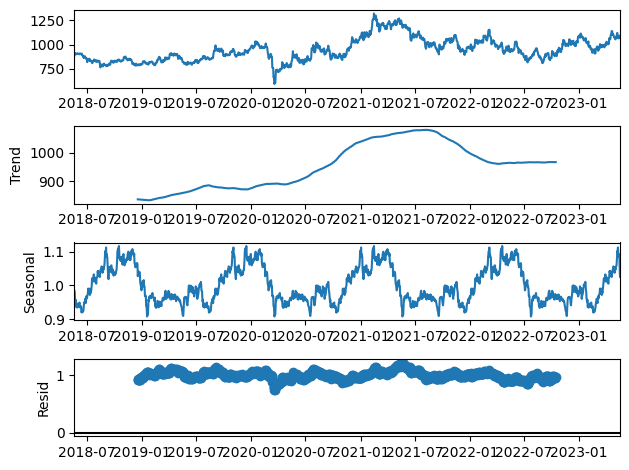

In [10]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

# Split dataset (7-2-1)

---



In [11]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.Price.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)
  
  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val.tail(len(val)))
  print('MAE: ', val_mae)

  val_value = val.Price.values
  pred_val_value = pred_val.tail(len(val)).values
  val_ape = np.abs((val_value - pred_val_value) / val_value)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val.tail(len(val)))
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [12]:
# Spilit data (7-2-1)
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

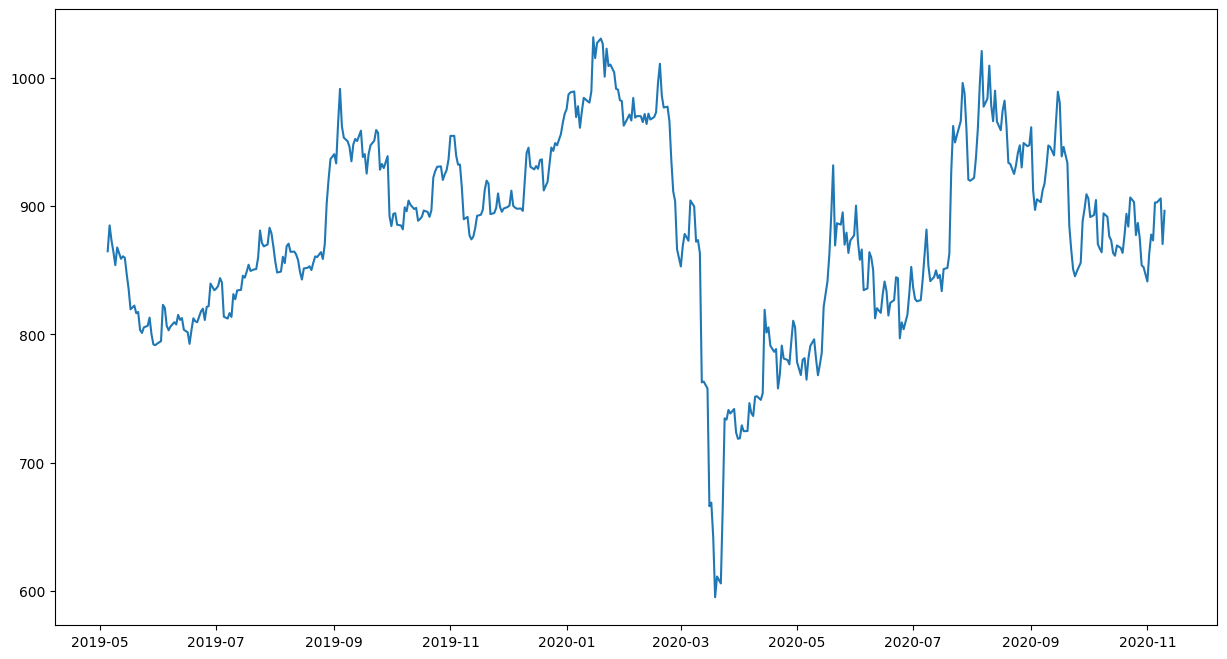

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[300:777], train['Price'][300:777]);

In [14]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=460, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val)) 
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


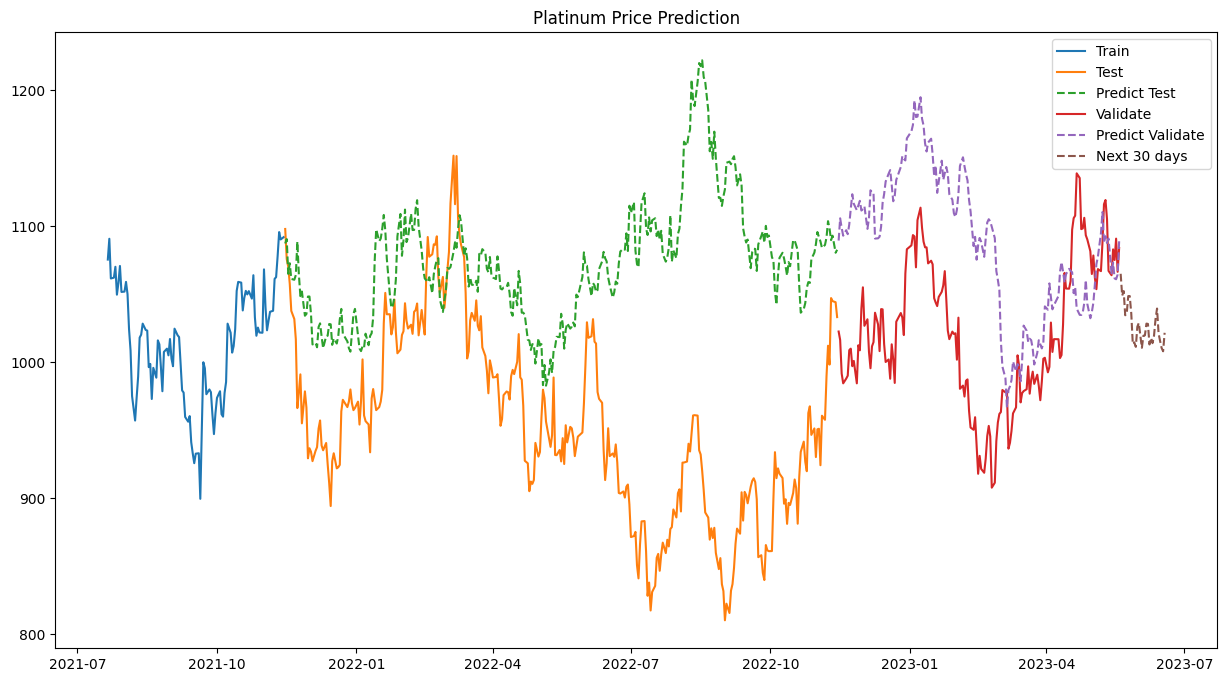

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Platinum Price Prediction");

In [17]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  121.53714784259365
MAPE:  13.357955211964656
RMSE:  148.50038856188124

** Validate **
MAE:  76.71380297643337
MAPE:  7.635498124522577
RMSE:  90.67123189142676


In [18]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                 1090
Model:             ExponentialSmoothing   SSE                         178746.885
Optimized:                         True   AIC                           6488.774
Trend:                   Multiplicative   BIC                           8810.953
Seasonal:                Multiplicative   AICC                          7191.527
Seasonal Periods:                   460   Date:                 Fri, 09 Jun 2023
Box-Cox:                          False   Time:                         21:30:21
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9242699                alpha                 True
smoothing_trend       

# Split dataset (6-3-1)

---

In [19]:
# Spilit data (6-3-1)
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [20]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=394, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val)) 
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return 

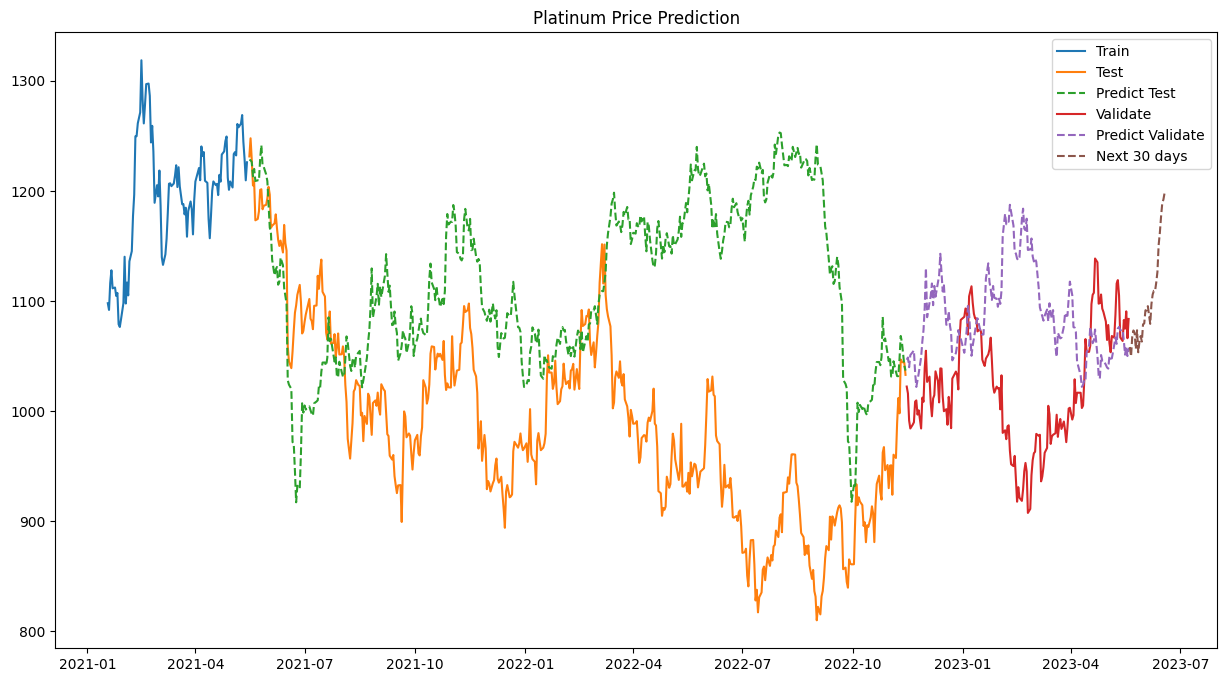

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Platinum Price Prediction");

In [23]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  140.77608837386023
MAPE:  15.047758724067704
RMSE:  175.4110881297065

** Validate **
MAE:  82.1207627142492
MAPE:  8.324149363655925
RMSE:  104.98026896671662


In [24]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  934
Model:             ExponentialSmoothing   SSE                         135545.683
Optimized:                         True   AIC                           5447.067
Trend:                   Multiplicative   BIC                           7378.018
Seasonal:                Multiplicative   AICC                          6053.089
Seasonal Periods:                   394   Date:                 Fri, 09 Jun 2023
Box-Cox:                          False   Time:                         21:30:44
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9242726                alpha                 True
smoothing_trend       

# Split Dataset (5-3-2)

---



In [25]:
# Spilit data (5-3-2)
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [26]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=333, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val)) 
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


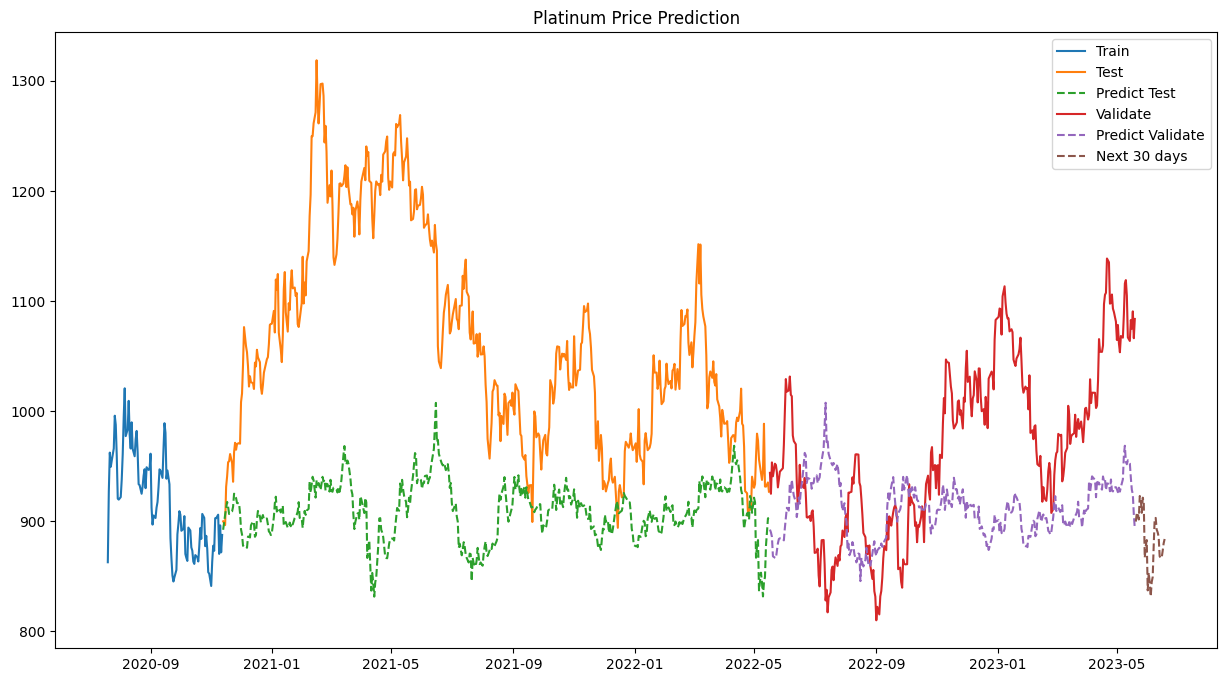

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Platinum Price Prediction");

In [29]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  154.19292968096008
MAPE:  13.851400676685213
RMSE:  181.3750923421609

** Validate **
MAE:  81.09867462246746
MAPE:  8.146727441607855
RMSE:  96.06489221519921


In [30]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  779
Model:             ExponentialSmoothing   SSE                         100583.006
Optimized:                         True   AIC                           4462.507
Trend:                   Multiplicative   BIC                           6036.914
Seasonal:                Multiplicative   AICC                          4991.913
Seasonal Periods:                   333   Date:                 Fri, 09 Jun 2023
Box-Cox:                          False   Time:                         21:31:02
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9949863                alpha                 True
smoothing_trend       

# Evaluating Model

---
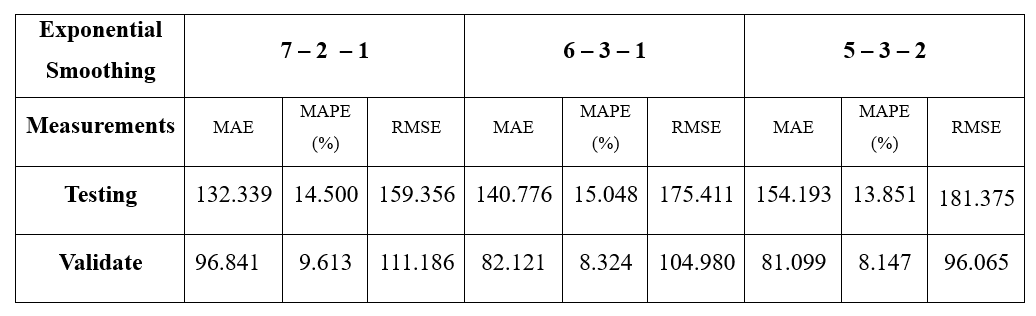
